# Simulation: time series with heteroscedastic errors

## Colab environment setup

In [ ]:
!git clone https://github.com/Jayaos/TCPTS

In [1]:
!pip install sklearn_quantile==0.0.29
!pip install scikit-learn==1.1.2
!pip install omegaconf==2.3.0

In [2]:
%cd /content/TCPTS/
!pwd

/content/TCPTS
/content/TCPTS


## Load packages and data

In [3]:
from src.SPCI import *
from src.utils import *
import matplotlib.pyplot as plt

In [4]:
hetero_data_dict = load_data("./data/hetero_100_data_dict.pkl")

[]

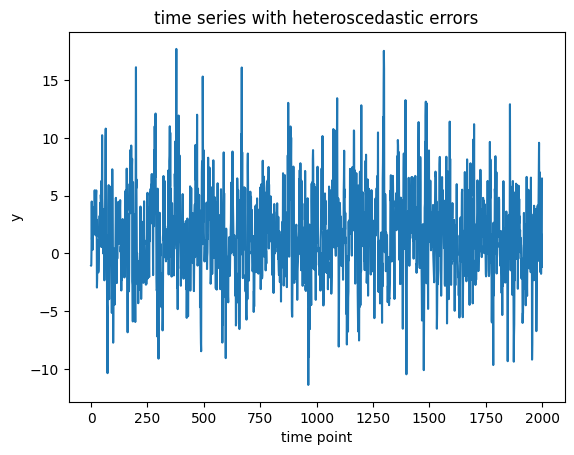

In [33]:
plt.plot(hetero_data_dict["y"])
plt.xlabel("time point")
plt.ylabel("y")
plt.title("time series with heteroscedastic errors")
plt.plot()

## Fitting point predictor

In [6]:
X_full = torch.Tensor(hetero_data_dict["x"])
Y_full = torch.Tensor(hetero_data_dict["y"])

In [7]:
X_full.shape

torch.Size([2000, 10])

In [8]:
# Use 80% for training
train_frac = 0.8
N = int(X_full.shape[0] * train_frac)
X_train, X_predict, Y_train, Y_predict = X_full[:N], X_full[N:], Y_full[:N], Y_full[N:]

In [9]:
fit_func = RandomForestRegressor(n_estimators=10, max_depth=1, criterion='squared_error',
                                bootstrap=False, n_jobs=-1, random_state=1103)
SPCI_class  = SPCI_and_EnbPI(X_train, X_predict, Y_train, Y_predict, fit_func=fit_func)
stride = 1
SPCI_class.fit_bootstrap_models_online_multistep(B = 25, fit_sigmaX=False, stride=stride)
alpha = 0.1 # 90% prediction interval

1/1 multi-step: finish Fitting 25 Bootstrap models, took 1.2095189094543457 secs.


## Conformal prediction using Transformer decoder as a conditional quantile estimator

In [10]:
SPCI_class.set_standardizer() # data standardizer

setting and fitting standardizer...
setting and fitting standardizer done


In [11]:
# use 10% of entire data for validation and testing, respectively
SPCI_class.split_validation_test(0.5)

splitting predict set into validation and test set...


In [27]:
# setting saving directory
%mkdir "../results/"
%mkdir "../results/hetero/"
SAVING_DIR = "../results/hetero/"

In [34]:
# setting hyperparameters
STRIDE=1
PAST_WINDOW=100
# target quantiles should be given as a list where
# TARGET_QUANTILES[i] - TARGET_QUANTILES[-(i+1)] = target coverage
# in this example with i=0
# TARGET_QUANTILES[0] - TARGET_QUANTILES[-1] = 0.975 - 0.075 = 0.9 since we set target coverage to 0.9
TARGET_QUANTILES=[0.975,0.95,0.925,0.5,0.025,0.05,0.075]
DIM_MODEL=16
NUM_HEAD=4
DIM_FF=DIM_MODEL*4
NUM_LAYERS=4
DROPOUT=0.2
MAX_EPOCH=50
ADDITIONAL_TRAINING_EPOCH=0
BATCH_SIZE=4
LEARNING_RATE=0.0001
EARLY_STOP=3 # If validation loss does not improve for 3 epochs, end training
STANDARDIZE=False # To standardize data


In [ ]:
SPCI_class.compute_online_QGPT_SPCI_single_training(SAVING_DIR, STRIDE, PAST_WINDOW,
                                                    TARGET_QUANTILES, DIM_FF, NUM_HEAD, DIM_FF, NUM_LAYERS, DROPOUT,
                                                    MAX_EPOCH, ADDITIONAL_TRAINING_EPOCH,
                                                    BATCH_SIZE, LEARNING_RATE, EARLY_STOP, standardize=STANDARDIZE)

setting up dataset...
setting up dataset done
initialize models...
initialize models done


100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


training loss at epoch 1: 5.604459684371948


100%|██████████| 50/50 [00:00<00:00, 57.26it/s]


validation loss at epoch 1: 3.246693549156189


100%|██████████| 375/375 [00:20<00:00, 17.91it/s]


training loss at epoch 2: 3.8082182534535725


100%|██████████| 50/50 [00:00<00:00, 58.63it/s]


validation loss at epoch 2: 2.80074125289917


100%|██████████| 375/375 [00:20<00:00, 17.97it/s]


training loss at epoch 3: 3.417278217951457


100%|██████████| 50/50 [00:00<00:00, 61.83it/s]


validation loss at epoch 3: 2.7525843811035156


 40%|████      | 151/375 [00:07<00:11, 19.54it/s]

## Multi-step conformal prediction using Transformer decoder as a conditional quantile estimator

Multi-step conformal prediction requires the results (trained model, result dict, and hyperparameters dict) from the previous cell.

In [30]:
MODEL_DIR=SAVING_DIR+"QGPT_best_model.pt"
HYPERPARAMS_DIR=SAVING_DIR+"QGPT_SPCI_hyperparms_dict.pkl"
RESULTS_DICT_DIR=SAVING_DIR+"QGPT_SPCI_result_dict.pkl"
NUM_MULTI_STEP=3

In [32]:
SPCI_class.predict_QGPT_multistep(MODEL_DIR, HYPERPARAMS_DIR, RESULTS_DICT_DIR, NUM_MULTI_STEP)

standardizing data...
standardizing data done
predicting 1-step ahead
setting up dataset...
setting up dataset done


100%|██████████| 200/200 [00:00<00:00, 205.14it/s]


(200,)
quantile pair: 0.975 , 0.075
coverage_ratio: 0.83
average CI width: 8.861498832702637
-------------------------------
quantile pair: 0.95 , 0.05
coverage_ratio: 0.84
average CI width: 9.204187393188477
-------------------------------
quantile pair: 0.925 , 0.025
coverage_ratio: 0.885
average CI width: 9.537893295288086
-------------------------------
predicting 2-step ahead
setting up dataset...
setting up dataset done


100%|██████████| 199/199 [00:01<00:00, 198.42it/s]


(199,)
quantile pair: 0.975 , 0.075
coverage_ratio: 0.7788944723618091
average CI width: 8.980316162109375
-------------------------------
quantile pair: 0.95 , 0.05
coverage_ratio: 0.8140703517587939
average CI width: 9.307164192199707
-------------------------------
quantile pair: 0.925 , 0.025
coverage_ratio: 0.8492462311557789
average CI width: 9.652040481567383
-------------------------------
predicting 3-step ahead
setting up dataset...
setting up dataset done


100%|██████████| 198/198 [00:01<00:00, 195.35it/s]

(198,)
quantile pair: 0.975 , 0.075
coverage_ratio: 0.7525252525252525
average CI width: 9.102935791015625
-------------------------------
quantile pair: 0.95 , 0.05
coverage_ratio: 0.7727272727272727
average CI width: 9.452217102050781
-------------------------------
quantile pair: 0.925 , 0.025
coverage_ratio: 0.8535353535353535
average CI width: 9.764500617980957
-------------------------------


([array([[[-0.7852825 , -0.13736433, -1.4239109 , ..., -0.26089346,
           -0.95683366, -0.21901736],
          [ 0.21183798,  0.11771791,  0.23145208, ...,  0.05488468,
           -0.6956324 ,  0.03343663],
          [-1.2584519 , -0.77338237, -0.5820395 , ..., -0.71974355,
           -1.5106573 , -0.9905488 ],
          ...,
          [ 0.8771117 ,  1.4016985 , -0.01462865, ...,  1.721755  ,
            0.39543274,  0.4468471 ],
          [-0.6309918 , -0.99806696,  2.7435157 , ..., -0.96456116,
            0.96665317,  1.8988229 ],
          [ 1.3040562 , -0.18350728,  2.5621142 , ..., -0.27619964,
            1.4697345 ,  0.22723137]],
  
         [[ 0.21183798,  0.11771791,  0.23145208, ...,  0.05488468,
           -0.6956324 ,  0.03343663],
          [-1.2584519 , -0.77338237, -0.5820395 , ..., -0.71974355,
           -1.5106573 , -0.9905488 ],
          [ 0.30228856, -0.1037015 ,  0.03635006, ..., -0.02109475,
           -0.8981    , -0.23143001],
          ...,
          [-